In [38]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,classification_report)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [39]:
# Absolute paths you provided
TRAIN_PATH = Path(r"C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction\data\data_raw\customer_churn_dataset-training-master.csv")
TEST_PATH = Path(r"C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction\data\data_raw\customer_churn_dataset-testing-master.csv")
SAMPLE_PATH = Path(r"C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction\data\data_raw\sample_customers.csv")

In [40]:
PROJECT_ROOT = Path(r"C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction")
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

print("Train file exists:", TRAIN_PATH.exists())
print("Test file exists:", TEST_PATH.exists())
print("Sample file exists:", SAMPLE_PATH.exists())

Train file exists: True
Test file exists: True
Sample file exists: True


In [41]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)
sample_df = pd.read_csv(SAMPLE_PATH)

train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [42]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (440833, 12)
Test shape: (64374, 12)


In [43]:
print("\nColumns:", train_df.columns.tolist())


Columns: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


In [44]:
print("\nTrain Info:")
display(train_df.info())


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


None

In [45]:
print("\nTrain Describe:")
display(train_df.describe(include='all').T)


Train Describe:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,440832.0,NaN,NaN,NaN,225398.667955,129531.91855,2.0,113621.75,226125.5,337739.25,449999.0
Age,440832.0,NaN,NaN,NaN,39.373153,12.442369,18.0,29.0,39.0,48.0,65.0
Gender,440832,2,Male,250252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,440832.0,NaN,NaN,NaN,31.256336,17.255727,1.0,16.0,32.0,46.0,60.0
Usage Frequency,440832.0,NaN,NaN,NaN,15.807494,8.586242,1.0,9.0,16.0,23.0,30.0
Support Calls,440832.0,NaN,NaN,NaN,3.604437,3.070218,0.0,1.0,3.0,6.0,10.0
Payment Delay,440832.0,NaN,NaN,NaN,12.965722,8.258063,0.0,6.0,12.0,19.0,30.0
Subscription Type,440832,3,Standard,149128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contract Length,440832,3,Annual,177198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Spend,440832.0,NaN,NaN,NaN,631.616223,240.803001,100.0,480.0,661.0,830.0,1000.0


In [46]:
print("\nTarget distribution (train):")
print(train_df["Churn"].value_counts(normalize=True) * 100)


Target distribution (train):
Churn
1.0    56.71072
0.0    43.28928
Name: proportion, dtype: float64


In [47]:
rename_map = {
    "Usage Frequency": "Usage",
    "Payment Delay": "PaymentDelay",
    "Subscription Type": "Subscription",
    "Contract Length": "Contract",
    "Total Spend": "TotalSpend",
    "Last Interaction": "LastInteraction",}

train_df = train_df.rename(columns=rename_map)
test_df  = test_df.rename(columns=rename_map)
sample_df = sample_df.rename(columns=rename_map)

train_df.head()

,CustomerID,Age,Gender,Tenure,Usage,Support Calls,PaymentDelay,Subscription,Contract,TotalSpend,LastInteraction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [48]:
TARGET_COL = "Churn"
ID_COL = "CustomerID" if "CustomerID" in train_df.columns else None

feature_cols = [c for c in train_df.columns if c not in [TARGET_COL, ID_COL]]
numeric_features = ["Age","Tenure","Usage","Support Calls","PaymentDelay","TotalSpend","LastInteraction"]
categorical_features = ["Gender","Subscription","Contract"]

In [49]:
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['Age', 'Tenure', 'Usage', 'Support Calls', 'PaymentDelay', 'TotalSpend', 'LastInteraction']
Categorical: ['Gender', 'Subscription', 'Contract']


In [50]:
label_map = {"Yes":1,"No":0,"Active":0,"Churned":1,"Exited":1,"Stayed":0}
y_raw = train_df[TARGET_COL]

if y_raw.dtype == "O":
    y_num = y_raw.map(label_map)
else:
    y_num = y_raw

mask = y_num.notna()
train_df = train_df.loc[mask].copy()
y_num = y_num.loc[mask].astype(int)

X = train_df[feature_cols]
y = y_num

print("Final shapes after cleaning:", X.shape, y.shape)

Final shapes after cleaning: (440832, 10) (440832,)


In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape)
print("Valid:", X_valid.shape)

Train: (352665, 10)
Valid: (88167, 10)


In [53]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])

# Model Building

## Logistic regression

In [54]:
log_reg_model = Pipeline([("prep", preprocessor),("logreg", LogisticRegression(max_iter=500))])

 VALIDATION SET PERFORMANCE (threshold = 0.5)

Logistic Regression (Val) (threshold = 0.50)
Accuracy : 0.8934
F1-score : 0.9040
ROC AUC  : 0.9590

Classification report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     38167
           1       0.92      0.89      0.90     50000

    accuracy                           0.89     88167
   macro avg       0.89      0.89      0.89     88167
weighted avg       0.89      0.89      0.89     88167



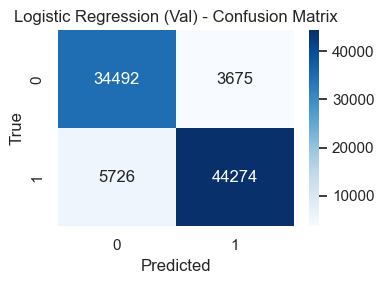

In [59]:
print(" VALIDATION SET PERFORMANCE (threshold = 0.5)")
val_metrics = {}
val_metrics["Logistic Regression"] = evaluate_model(
    "Logistic Regression (Val)", log_reg_model, X_valid, y_valid, threshold=0.5
)

## Random Forest

In [55]:
rf_model = Pipeline([("prep", preprocessor),("rf", RandomForestClassifier(
        n_estimators=300,random_state=42,class_weight="balanced"))
                    ])


Random Forest (Val) (threshold = 0.50)
Accuracy : 0.9993
F1-score : 0.9994
ROC AUC  : 1.0000

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38167
           1       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



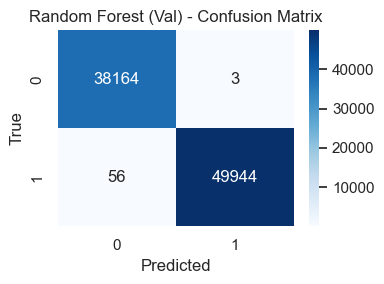

In [60]:
val_metrics["Random Forest"] = evaluate_model(
    "Random Forest (Val)", rf_model, X_valid, y_valid, threshold=0.5)

## XGB Classifier

In [56]:
xgb_model = Pipeline([("prep", preprocessor),("xgb", XGBClassifier(
        n_estimators=300,learning_rate=0.06,max_depth=6,subsample=0.9,colsample_bytree=0.9,eval_metric="logloss",random_state=42))
                     ])


XGBoost (Val) (threshold = 0.50)
Accuracy : 0.9999
F1-score : 0.9999
ROC AUC  : 1.0000

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38167
           1       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



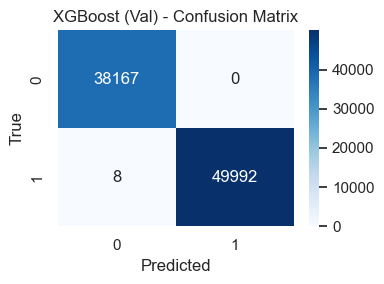

In [61]:
val_metrics["XGBoost"] = evaluate_model(
    "XGBoost (Val)", xgb_model, X_valid, y_valid, threshold=0.5)

In [57]:
log_reg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Tenure', 'Usage',
                                                   'Support Calls',
                                                   'PaymentDelay', 'TotalSpend',
                                                   'LastInteraction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Subscription',
                                                   'Contract'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.06,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [58]:
def evaluate_model(name, model, X, y, threshold=0.5):
    """
    Prints metrics and plots confusion matrix for a given model.
    Uses predict_proba + threshold for classification.
    """
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc = roc_auc_score(y, y_proba)

    print(f"\n==============================")
    print(f"{name} (threshold = {threshold:.2f})")
    print(f"==============================")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {roc:.4f}\n")

    print("Classification report:\n")
    print(classification_report(y, y_pred))

    # Confusion matrix plot
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {"accuracy": acc, "f1": f1, "roc_auc": roc}

### Evaluation Metrics

 TEST SET PERFORMANCE (threshold = 0.5)

Logistic Regression (Test) (threshold = 0.50)
Accuracy : 0.5712
F1-score : 0.6864
ROC AUC  : 0.6894

Classification report:

              precision    recall  f1-score   support

           0       0.96      0.19      0.32     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.57     64374
   macro avg       0.74      0.59      0.50     64374
weighted avg       0.75      0.57      0.49     64374



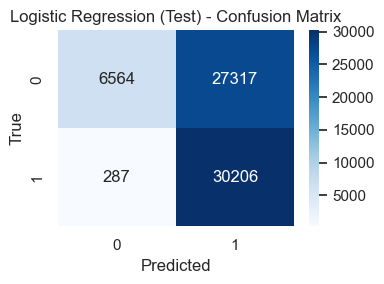

In [62]:
print(" TEST SET PERFORMANCE (threshold = 0.5)")

test_metrics = {}
test_metrics["Logistic Regression"] = evaluate_model(
    "Logistic Regression (Test)", log_reg_model, X_test, y_test, threshold=0.5)


Random Forest (Test) (threshold = 0.50)
Accuracy : 0.5039
F1-score : 0.6560
ROC AUC  : 0.6346

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



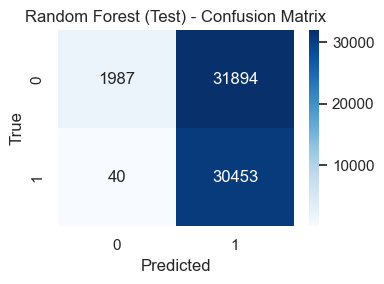

In [63]:
test_metrics["Random Forest"] = evaluate_model(
    "Random Forest (Test)", rf_model, X_test, y_test, threshold=0.5
)


XGBoost (Test) (threshold = 0.50)
Accuracy : 0.5034
F1-score : 0.6558
ROC AUC  : 0.7302

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



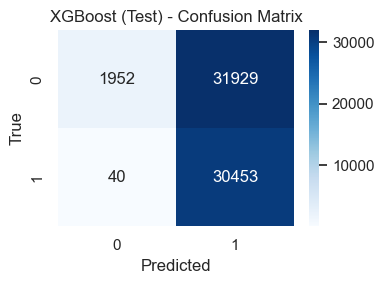

In [64]:
test_metrics["XGBoost"] = evaluate_model(
    "XGBoost (Test)", xgb_model, X_test, y_test, threshold=0.5
)


 Using tuned RF threshold: 0.337

Random Forest (Val, tuned thr) (threshold = 0.34)
Accuracy : 0.9999
F1-score : 1.0000
ROC AUC  : 1.0000

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38167
           1       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



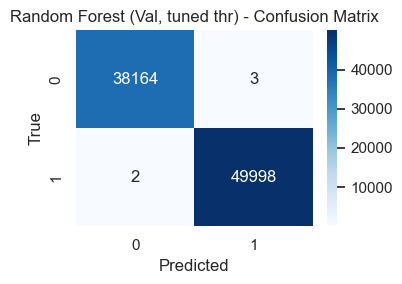

In [65]:
print(f"\n Using tuned RF threshold: {best_thr:.3f}")

rf_val_tuned  = evaluate_model(
    "Random Forest (Val, tuned thr)", rf_model, X_valid, y_valid, threshold=best_thr
)


Random Forest (Test, tuned thr) (threshold = 0.34)
Accuracy : 0.5033
F1-score : 0.6558
ROC AUC  : 0.6346

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



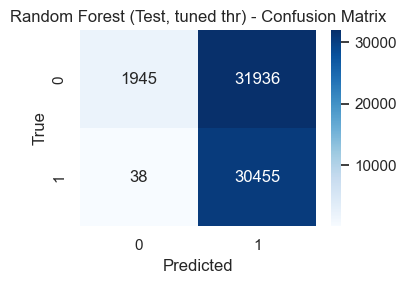

In [66]:
rf_test_tuned = evaluate_model(
    "Random Forest (Test, tuned thr)", rf_model, X_test, y_test, threshold=best_thr)

In [67]:
FINAL_MODEL_PATH = MODEL_DIR / "churn_xgb.joblib"

bundle = {
    "pipeline": rf_model,"threshold": best_thr}

joblib.dump(bundle, FINAL_MODEL_PATH)

print("Model saved →", FINAL_MODEL_PATH)

Model saved → C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction\models\churn_xgb.joblib


In [68]:
print("Sample columns:", sample_df.columns.tolist())
print("Expected feature_cols:", feature_cols)

missing_in_sample = [c for c in feature_cols if c not in sample_df.columns]
print("\nMissing columns in sample_df:", missing_in_sample)

for col in missing_in_sample:
    sample_df[col] = 0

# Reorder columns exactly like training
sample_features = sample_df[feature_cols].copy()

sample_probs = rf_model.predict_proba(sample_features)[:, 1]
sample_preds = (sample_probs >= best_thr).astype(int)

# Build full result dataframe
sample_results = sample_df.copy()
sample_results["Churn_Probability"] = sample_probs
sample_results["Churn_Prediction"] = sample_preds

sample_results.head()

Sample columns: ['Age', 'Gender', 'Tenure', 'Usage', 'Support', 'PaymentDelay', 'Subscription', 'Contract', 'TotalSpend', 'LastInteraction', 'Churn']
Expected feature_cols: ['Age', 'Gender', 'Tenure', 'Usage', 'Support Calls', 'PaymentDelay', 'Subscription', 'Contract', 'TotalSpend', 'LastInteraction']

Missing columns in sample_df: ['Support Calls']


,Age,Gender,Tenure,Usage,Support,PaymentDelay,Subscription,Contract,TotalSpend,LastInteraction,Churn,Support Calls,Churn_Probability,Churn_Prediction
0,30,Female,12,20,2,0,Basic,Monthly,300,10,0,0,1.000000,1
1,48,Male,36,45,5,2,Standard,Quarterly,1500,5,1,0,0.316667,0
2,26,Other,6,12,1,0,Basic,Monthly,120,14,0,0,1.000000,1
3,59,Female,60,70,4,3,Premium,Annual,5200,2,1,0,0.956667,1
4,41,Male,24,30,2,1,Standard,Quarterly,980,7,0,0,0.003333,0


In [69]:
REPORT_DIR = PROJECT_ROOT / "reports"
REPORT_DIR.mkdir(exist_ok=True, parents=True)

out_path = REPORT_DIR / "sample_customers_predictions.csv"
sample_results.to_csv(out_path, index=False)

print("✅ Sample predictions saved to:", out_path)

✅ Sample predictions saved to: C:\Users\srida\OneDrive\Desktop\repos\customer-churn-prediction\reports\sample_customers_predictions.csv
